In [18]:
import numpy as np

def read_xyz(file_path):
    """Reads the XYZ file and returns the list of steps with atom coordinates."""
    steps = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        i = 0
        while i < len(lines):
            if lines[i].strip().isdigit():
                atom_count = int(lines[i].strip()) + 1  # Number of atoms
                comment_line = lines[i + 1].strip()  # Comment line, can be disregarded
                atom_lines = lines[i + 2:i + 2 + atom_count]  # Atom lines (with atom name)
                steps.append(atom_lines)
                i += 2 + atom_count  # Move to the next step
            else:
                i += 1  # Skip lines that don't match the expected format
    return steps

def pbc_correction(coord, box_length):
    """Applies periodic boundary condition corrections to coordinates."""
    half_box = box_length / 2.0
    return coord - box_length * np.floor((coord + half_box) / box_length)

def compute_mean_of_selected_atoms(step_atoms, selected_indices, box_lengths):
    """Computes the mean x, y, z coordinates of selected atoms, considering PBC."""
    coords = []
    
    for i in selected_indices:
        if i < len(step_atoms):  # Ensure index is within range
            try:
                # Extract coordinates (ignore atom name)
                atom_coords = list(map(float, step_atoms[i].split()[1:4]))
                coords.append(atom_coords)
            except (IndexError, ValueError):
                print(f"Error processing atom at index {i} in the current step.")
        else:
            print(f"Index {i} out of bounds for this step.")
    
    if not coords:
        raise ValueError("No valid atom coordinates found for the selected indices.")
    
    coords = np.array(coords)

    # Apply periodic boundary correction for each coordinate axis
    corrected_coords = np.zeros_like(coords)
    for i in range(3):  # 3 dimensions: x, y, z
        corrected_coords[:, i] = pbc_correction(coords[:, i], box_lengths[i])
    
    # Compute the mean of corrected coordinates
    mean_coords = np.mean(corrected_coords, axis=0)
    
    return mean_coords

def process_xyz(file_path, output_path, selected_indices, box_lengths):
    """Processes the XYZ file, computes mean for selected atoms, and appends the mean."""
    steps = read_xyz(file_path)
    with open(output_path, 'w') as output_file:
        for step in steps:
            # The number of atoms in this step
            atom_count = len(step)
            
            # Write the header (atom count and comment line)
            output_file.write(f"{atom_count}\n")
            output_file.write("\n")  # Customize as needed
            
            # Compute the mean of the selected atoms
            try:
                mean_coords = compute_mean_of_selected_atoms(step, selected_indices, box_lengths)
            except ValueError as e:
                print(f"Skipping step due to error: {e}")
                continue
            
            # Write the atom lines (preserving the atom name) without extra newlines
            for atom in step:
                output_file.write(atom.rstrip() + '\n')  # Remove any trailing newlines from the atom line
            
            # Append the mean coordinates at the end of each step
            mean_line = f"Mean {mean_coords[0]:.5f} {mean_coords[1]:.5f} {mean_coords[2]:.5f}\n"
            output_file.write(mean_line)


# Example usage
file_path = '/home/sal/qmcf_examples/graphite_qmmm_setup/aq_as_substrate/aq_with_shake/put_on_graphene/graphite-md-02.xyz'  # Path to your input XYZ file
output_path = '/home/sal/qmcf_examples/graphite_qmmm_setup/aq_as_substrate/aq_with_shake/put_on_graphene/graphite-md-altered.xyz'  # Path to the output XYZ file
selected_indices = [1449, 1448, 1451, 1452, 1453, 1454]  # Replace with your list of atom indices
box_lengths = [29.64632933, 25.70241871, 100.00000000]  # Replace with your actual box dimensions

process_xyz(file_path, output_path, selected_indices, box_lengths)



In [31]:
import os
import pandas as pd

# Directory containing the .xyz files to analyze 
directory = '/home/sal/qmcf_examples/graphite_qmmm_setup/aq_as_substrate/aq_with_shake/put_on_graphene/'

# Save lattice parameters in separate dataframe
latticefilename = 'graphite-md-altered.xyz'
lattice = pd.read_csv(os.path.join(directory, latticefilename), delimiter='\s+', header=None, skiprows=range(2, 12500), nrows=1)

numAtoms = lattice[0][0] - 1

guest_indices = [1466] # Which atoms to track
dfs = []

x_values = []

# Loop through xyz files, create dataframes from them, clean them up, add indices and add them to the list of dataframes
for i, filename in enumerate(sorted(os.listdir(directory))):
    if filename.endswith('.xyz') and filename.startswith('graphite-md-altered'): #change prefix
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, delimiter='\s+', header=None, skiprows=1)
        df['run'] = filename
        # drop all rows that are NaN
        df = df[~df.iloc[:, 1].isna()]
        # drop all rows that are an X element
        df = df[df[0] != 'X']
        # reset the Index of the dataframe
        df.reset_index(drop=True, inplace=True)
        # add cleanedIndex to each row representing its index in the simulation, going from 1 to numAtoms then start at 1 again
        df['cleanedIndex'] = (df.index) % (numAtoms) + 1
        #drop the entire row if the cleanedIndex is not in the guest_indices list
        df = df[df['cleanedIndex'].isin(guest_indices)]
        # append to the list of dataframes
        print(df)
        print(df[df.iloc[:, 1].equals("Mean")])
        print(df)
        dfs.append(df)


        
# Concatenate all dataframes into one
df = pd.concat(dfs, ignore_index=True)
print(df)


Empty DataFrame
Columns: [0, 1, 2, 3, run, cleanedIndex]
Index: []
Series([], Name: 0, dtype: object)
Empty DataFrame
Columns: [0, 1, 2, 3, run, cleanedIndex]
Index: []
Empty DataFrame
Columns: [0, 1, 2, 3, run, cleanedIndex]
Index: []


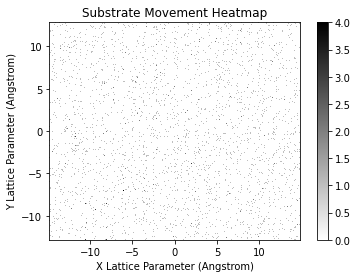

In [24]:
lattice_x = box_lengths[0]
lattice_y = box_lengths[1]

# Save second and third column of dataframe
x_values = df.iloc[:, 1]
y_values = df.iloc[:, 2]

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Adjust x-axis range and center it at zero
plt.hist2d(x_values, y_values, bins=500, cmap='binary', range=[[-lattice_x/2, lattice_x/2], [-lattice_y/2, lattice_y/2]])
plt.colorbar()
plt.xlabel('X Lattice Parameter (Angstrom)')
plt.ylabel('Y Lattice Parameter (Angstrom)')
plt.title('Substrate Movement Heatmap')

plt.gca().set_aspect('equal')  # Set aspect ratio to 'equal'+
plt.savefig("/home/sal/Desktop/Heatmap_aq.png", dpi = 300)

plt.show()

0         3.1764
1         3.0999
2         3.1714
3         3.2694
4         3.3207
           ...  
149995    3.7330
149996    3.6888
149997    3.5552
149998    3.3438
149999    3.5530
Name: 3, Length: 150000, dtype: float64


FileNotFoundError: [Errno 2] No such file or directory: '/home/mfi/Desktop/mfi/images/Histogram2Guest.png'

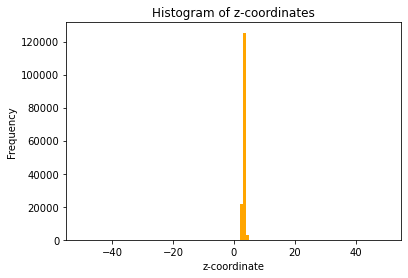

In [7]:
z_lattice = lattice[3][0]
z_values = df.iloc[:, 3]
print(z_values)

#Plot a histogram of the z values
plt.hist(z_values, bins=100, color='orange' ,range=[-z_lattice/2, z_lattice/2])
plt.xlabel('z-coordinate')
plt.ylabel('Frequency')
plt.title('Histogram of z-coordinates')
plt.savefig("/home/mfi/Desktop/mfi/images/Histogram2Guest.png")

plt.show()



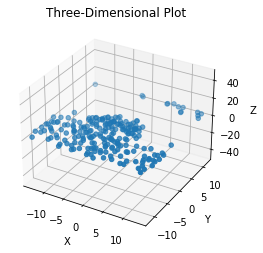

In [29]:
# Create a new figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot every thousandth step
ax.scatter(x_values[::1000], y_values[::1000], z_values[::1000])

# Set ranges to lattice values
ax.set_xlim(-lattice_x/2, lattice_x/2)
ax.set_ylim(-lattice_y/2, lattice_y/2)
ax.set_zlim(-z_lattice/2, z_lattice/2)


# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Three-Dimensional Plot')

# Show the plot
plt.show()